In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from pandas.plotting import scatter_matrix


In [5]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [6]:
results = pd.read_csv('results.csv')
driver_standings = pd.read_csv('driver_standings.csv')
constructor_standings = pd.read_csv('constructor_standings.csv')

In [7]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [8]:
results.dtypes

resultId             int64
raceId               int64
driverId             int64
constructorId        int64
number              object
grid                 int64
position            object
positionText        object
positionOrder        int64
points             float64
laps                 int64
time                object
milliseconds        object
fastestLap          object
rank                object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
dtype: object

In [9]:
driver_standings.head()

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


In [10]:
driver_standings.dtypes

driverStandingsId      int64
raceId                 int64
driverId               int64
points               float64
position               int64
positionText          object
wins                   int64
dtype: object

In [11]:
constructor_standings.head()

,constructorStandingsId,raceId,constructorId,points,position,positionText,wins
0,1,18,1,14.0,1,1,1
1,2,18,2,8.0,3,3,0
2,3,18,3,9.0,2,2,0
3,4,18,4,5.0,4,4,0
4,5,18,5,2.0,5,5,0


In [12]:
constructor_standings.dtypes

constructorStandingsId      int64
raceId                      int64
constructorId               int64
points                    float64
position                    int64
positionText               object
wins                        int64
dtype: object

# Data Cleaning and Data Analysis

## We only need few columns from the datasets above, so dropping 

In [15]:
results = results[["raceId", "driverId", "constructorId", "grid", "position"]]
results.head()

,raceId,driverId,constructorId,grid,position
0,18,1,1,1,1
1,18,2,2,5,2
2,18,3,3,7,3
3,18,4,4,11,4
4,18,5,1,3,5


#### Renamed the "position" column do avoid conflict with the "position" column from results dataset

In [16]:
driver_standings = driver_standings[["raceId", "driverId", "position"]]
# Rename the "position" column do avoid conflict with the "position" column from results.csv
driver_standings = driver_standings.rename(columns={"position": "driverStanding"})
# Use current driver standings for the next race
driver_standings["raceId"] += 1
driver_standings.head()

,raceId,driverId,driverStanding
0,19,1,1
1,19,2,2
2,19,3,3
3,19,4,4
4,19,5,5


#### Selecting the columns we need and also renaming the positions column in constructions standing dataset

In [17]:
constructor_standings = constructor_standings[["raceId", "constructorId", "position"]]
constructor_standings = constructor_standings.rename(columns={"position": "constructorStanding"})
constructor_standings["raceId"] += 1
constructor_standings.head()

,raceId,constructorId,constructorStanding
0,19,1,1
1,19,2,3
2,19,3,2
3,19,4,4
4,19,5,5


#### Joining results and standing datasets, this will later be merged with constructurs dataset, that should give us the complete dataset. 


In [19]:
results_driver_standings = pd.merge(results, driver_standings, on=["raceId", "driverId"], how="inner")
results_driver_standings.head()

,raceId,driverId,constructorId,grid,position,driverStanding
0,18,1,1,1,1,5
1,18,2,2,5,2,13
2,18,3,3,7,3,7
3,18,4,4,11,4,9
4,18,5,1,3,5,12


In [20]:
joined_data = pd.merge(results_driver_standings, constructor_standings, on=["raceId", "constructorId"], how="inner")
joined_data.head()

,raceId,driverId,constructorId,grid,position,driverStanding,constructorStanding
0,18,1,1,1,1,5,3
1,18,5,1,3,5,12,3
2,18,2,2,5,2,13,6
3,18,9,2,2,\N,14,6
4,18,3,3,7,3,7,7


In [22]:
len(joined_data)

22158

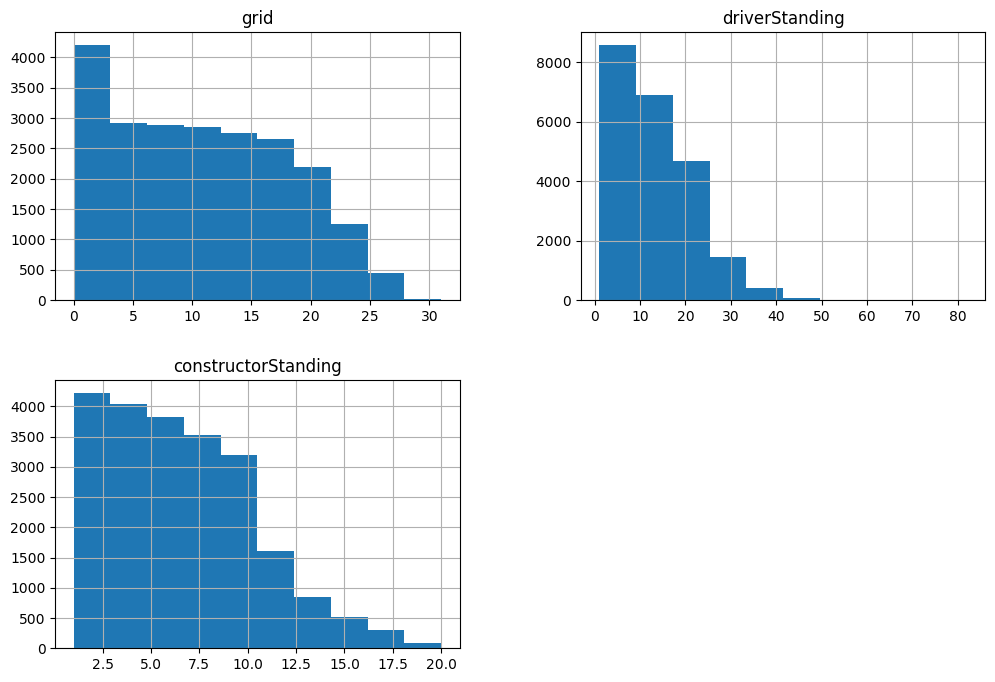

In [23]:
joined_data[["grid", "driverStanding", "constructorStanding", "position"]].hist(figsize=(12, 8))
plt.show()

In [24]:
joined_data[["grid", "driverStanding", "constructorStanding", "position"]].agg(['min', 'max'])

,grid,driverStanding,constructorStanding,position
min,0,1,1,1
max,31,82,20,\N


#### Grid positions show as 31, but thre can be a maximum of 20 cars and positinos. Have to clean the data again, maybe find number of records which have grid value more than 20 and if number is small, remove these values. 

In [27]:
#validating the records which have grid position over 20, there is a possiablity that these records are from past as in past 
#there were more cars allowed on the grid. 


In [29]:
racesDataset = pd.read_csv('races.csv')
racesDataset.loc[racesDataset['year'] == 2013].sort_values(by="raceId", ascending=True).head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
878,880,2013,1,1,Australian Grand Prix,2013-03-17,06:00:00,http://en.wikipedia.org/wiki/2013_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
879,881,2013,2,2,Malaysian Grand Prix,2013-03-24,08:00:00,http://en.wikipedia.org/wiki/2013_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
880,882,2013,3,17,Chinese Grand Prix,2013-04-14,07:00:00,http://en.wikipedia.org/wiki/2013_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
881,883,2013,4,3,Bahrain Grand Prix,2013-04-21,12:00:00,http://en.wikipedia.org/wiki/2013_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
882,884,2013,5,4,Spanish Grand Prix,2013-05-12,12:00:00,http://en.wikipedia.org/wiki/2013_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [30]:
# there are records order than 2013 with grid positions more than 20, we will be restricting the analysis to just current 10 years. 

In [31]:
joined_data = joined_data[joined_data["raceId"] > 880]
joined_data.head()

,raceId,driverId,constructorId,grid,position,driverStanding,constructorStanding
18241,881,20,9,1,1,3,3
18242,881,17,9,5,2,6,3
18243,881,1,131,4,3,5,4
18244,881,3,131,6,4,20,4
18245,881,13,6,2,5,4,1


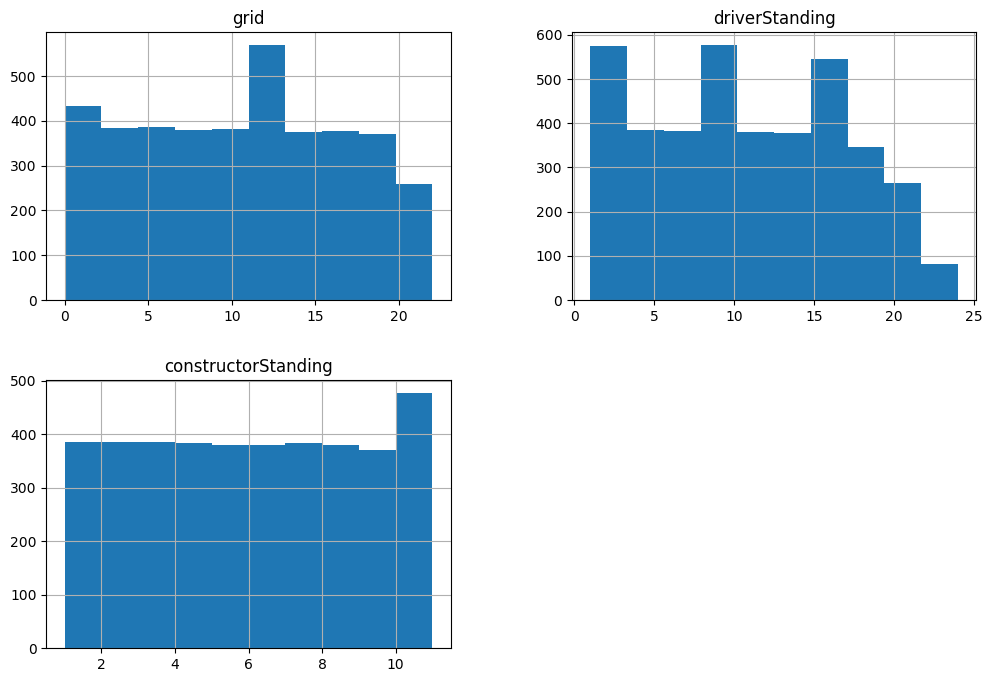

In [32]:
joined_data[["grid", "driverStanding", "constructorStanding", "position"]].hist(figsize=(12, 8))
plt.show()

In [35]:
## Getting rid of more columns. Also removing the records where the position value shows as \n, these are the NA vlues. 
# Any record without a racer is of no use for the analysis. Also will remove any record where the Grid position (position) shows as 0. 
# As drivers can not finish at 0 positinos. Even if someone retired the car, they would get a grid positions >0 and <=20. Furhter, 
# converted the text value to numeric for position column. 

In [33]:
dataset = joined_data[["grid", "driverStanding", "constructorStanding", "position"]]
joined_data.head()

,raceId,driverId,constructorId,grid,position,driverStanding,constructorStanding
18241,881,20,9,1,1,3,3
18242,881,17,9,5,2,6,3
18243,881,1,131,4,3,5,4
18244,881,3,131,6,4,20,4
18245,881,13,6,2,5,4,1


In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3916 entries, 18241 to 22157
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   grid                 3916 non-null   int64 
 1   driverStanding       3916 non-null   int64 
 2   constructorStanding  3916 non-null   int64 
 3   position             3916 non-null   object
dtypes: int64(3), object(1)
memory usage: 137.7+ KB


In [36]:
dataset = dataset[dataset.position.apply(lambda x: x.isnumeric())]

In [37]:
dataset = dataset[dataset.grid.apply(lambda x: x > 0)]

In [38]:
dataset.position = dataset.position.astype('int')

In [39]:
dataset

,grid,driverStanding,constructorStanding,position
18241,1,3,3,1
18242,5,6,3,2
18243,4,5,4,3
18244,6,20,4,4
18245,2,4,1,5
...,...,...,...,...
22153,18,10,6,15
22154,19,19,10,13
22155,20,20,10,19
22156,12,16,8,16


In [40]:
#now the dataset has reduced to just 3258 observations after cleaning the data.

## Model training and correlations 

In [41]:
#  We are checking the correlation coefficient between each label and each attribute. Closer to 1, stronger the corerelation. 

In [42]:
dataset.corr()["position"]

grid                   0.750109
driverStanding         0.742595
constructorStanding    0.750760
position               1.000000
Name: position, dtype: float64

In [43]:
# we observed there is a position corerelation between all the features. We are visualizing this even more

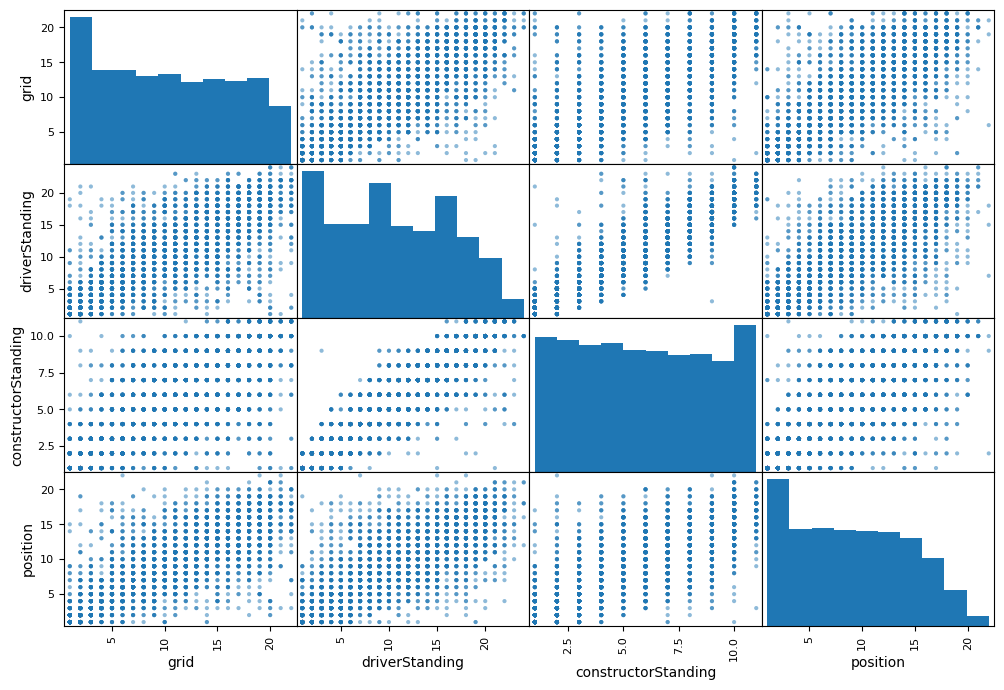

In [44]:
scatter_matrix(dataset, figsize=(12,8))
plt.show()

max_grid = 22; max_position = 22; max_d_position = 24; max_c_position = 11


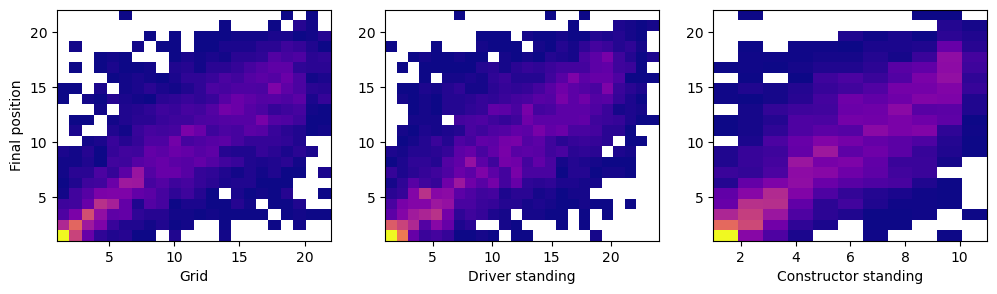

In [45]:
fig,ax = plt.subplots(1, 3, figsize=(12, 3))

# https://stackoverflow.com/a/20105673/3015186
max_grid = dataset.grid.max()
max_position = dataset.position.max()
max_d_position = dataset.driverStanding.max()
max_c_position = dataset.constructorStanding.max()
print(f"max_grid = {max_grid}; max_position = {max_position}; max_d_position = {max_d_position}; max_c_position = {max_c_position}")

ax[0].hist2d(dataset.grid, dataset.position, (max_grid, max_position), cmap='plasma', cmin=1)
ax[0].set_xlabel("Grid")
ax[0].set_ylabel("Final position")
ax[1].hist2d(dataset.driverStanding, dataset.position, (max_d_position, max_position), cmap='plasma', cmin=1)
ax[1].set_xlabel("Driver standing")
ax[2].hist2d(dataset.constructorStanding, dataset.position, (max_c_position, max_position), cmap='plasma', cmin=1)
ax[2].set_xlabel("Constructor standing")

plt.show()

### Creating test and training datasets

In [46]:
x_train <- dataset[['grid', 'driverStanding', 'constructorStanding']].values
y_train <- dataset[['position']].values.reshape(-1) 
print(f'{x_train.shape}; {y_train.shape}')
print(x_train)
print(y_train)

(3258, 3); (3258,)
[[ 1  3  3]
 [ 5  6  3]
 [ 4  5  4]
 ...
 [20 20 10]
 [12 16  8]
 [16 13  8]]
[ 1  2  3 ... 19 16 17]


In [47]:
## Implementing the cost function

In [48]:
def compute_cost(x, y, w, b):
    # Get number of examples
    m = x.shape[0]
    # Initialise cost
    cost = 0
    for i in range(m):
        f_wb_i = x[i].dot(w) + b
        cost += (f_wb_i - y[i]) ** 2
    return cost / (2 * m)

In [49]:
w_init = [0, 0, 0]
b_init = 0

In [50]:
cost = compute_cost(x_train, y_train, w_init, b_init)
print(f"Cost = {cost}")

Cost = 55.43278084714549


In [51]:
cost = compute_cost(x_train, y_train, [0.35008161, 0.04341071, 0.27482694], 2.0513445619234765)
print(f"Cost = {cost}")

Cost = 6.637608134053078


In [52]:
## after adding weights, cost went from over 55 down to around 6.

## Now we want to implement the gradient descent function for multiple variables. So we first calculate the gradient 

In [53]:
def compute_gradient(x, y, w, b):
    # Get number of examples and features
    m, n = x.shape
    # Initialise gradient of the cost w.r.t the parameters w
    dj_dw = np.zeros((n,))
    # Initialise gradient of the cost w.r.t the parameter b
    dj_db = 0.
    
    for i in range(m):
        loss = (x[i].dot(w) + b) - y[i] # Loss is the same for both derivatives
        for j in range (n):
            dj_dw[j] += loss * x[i][j] 
        dj_db += loss
    dj_dw = dj_dw / m
    dj_db = dj_db / m
    return dj_dw, dj_db

In [54]:
compute_gradient(x_train, y_train, w_init, b_init)

(array([-118.62400246, -120.44229589,  -61.77931246]), -9.169429097605892)

In [55]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    # Store history of costs (J). This will be used when we print out the progress.
    J_history = []

    w = copy.deepcopy(w_in)
    b = b_in
    
    # Apply gradient descent num_iters times
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        # Update w and b based on gradient, at the same time (this is important)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        
        J_history.append(compute_cost(X, y, w, b))
            
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.8f}   ")
    
    return w, b, J_history

In [56]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    # Store history of costs (J). This will be used when we print out the progress.
    J_history = []

    w = copy.deepcopy(w_in)
    b = b_in
    
    # Apply gradient descent num_iters times
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        # Update w and b based on gradient, at the same time (this is important)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        
        J_history.append(compute_cost(X, y, w, b))
            
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.8f}   ")
    
    return w, b, J_history

In [58]:
## Above we see that that over time the cost keeps decresing slow and eventually starts to converge. 
# It is not very obvious because the initial weights we used are already trained. 



In [66]:
import copy, math

# Initial values taken from a previous descent, so as not to start from 0
initial_w = np.array([0.37888087, 0.05009108, 0.32510837])
initial_b = 2.7796157637505052
iterations = 10000
alpha = 3.5e-3

print("Running gradient descent...")
w_final, b_final, J_hist = gradient_descent(x_train, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations)
print(f"b = {b_final}; w = {w_final} ")

Running gradient descent...
Iteration    0: Cost 4.98900555   
Iteration 1000: Cost 4.68054531   
Iteration 2000: Cost 4.62995299   
Iteration 3000: Cost 4.61832210   
Iteration 4000: Cost 4.61564821   
Iteration 5000: Cost 4.61503350   
Iteration 6000: Cost 4.61489218   
Iteration 7000: Cost 4.61485969   
Iteration 8000: Cost 4.61485222   
Iteration 9000: Cost 4.61485050   
b = 1.1346913859860654; w = [0.34919898 0.16862326 0.47748792] 


In [67]:
for i in range(10):
    f = x_train[i+100].dot(w_final) + b_final
    prediction = np.round(f).astype(int)
    actual = y_train[i+100]
    print(f"Prediction: {prediction:3d}, Actual position: {actual:3d}, Accuracy: {100 - (abs(prediction - actual) / actual) * 100.0:3.0f}%")

Prediction:   5, Actual position:   5, Accuracy: 100%
Prediction:   9, Actual position:   6, Accuracy:  50%
Prediction:  11, Actual position:  15, Accuracy:  73%
Prediction:  11, Actual position:   7, Accuracy:  43%
Prediction:   8, Actual position:  10, Accuracy:  80%
Prediction:   6, Actual position:   9, Accuracy:  67%
Prediction:  12, Actual position:  13, Accuracy:  92%
Prediction:  10, Actual position:  11, Accuracy:  91%
Prediction:  11, Actual position:  12, Accuracy:  92%
Prediction:   9, Actual position:  14, Accuracy:  64%


In [68]:
#Now let's see what's the avergae difference between our prediction and the actual result. In other words, by how many positions are we off on average when making the predictions.

In [69]:
differences = np.zeros(x_train.shape[0])
for i in range(x_train.shape[0]):
    f = x_train[i].dot(w_final) + b_final
    prediction = np.round(f).astype(int)
    actual = y_train[i]
    differences[i] = abs(prediction-actual)
print(f"Average difference: {np.average(differences):2.0f}")

Average difference:  2


In [70]:
def predict(grid, driver_standing, constructor_standing):
    prediction = np.array([grid, driver_standing, constructor_standing]).dot([0.34919898, 0.16862326, 0.47748792]) + 1.1346913859860654
    return np.round(prediction).astype(int)

In [72]:
predict(3, 5, 2)

4

## Testing the model

In [73]:
VER = predict(1, 1, 1)
HAM = predict(11, 3, 2)
LEC = predict(2, 5, 3)
print(f"Predictions: Max Verstappen - {VER}, Lewis Hamilton - {HAM}, Charles Leclerc - {LEC}")

Predictions: Max Verstappen - 2, Lewis Hamilton - 6, Charles Leclerc - 4


In [75]:
#The model is at above 80% accuracy. Actual finish of these drivers was Max:1 Leclerc: 3 Hamilton:9. This can be due to the fact
# we used data from past 10 years to train our model and since almost beginning, Mercedes have dominated so it pused up the position and 
# redbul recently started to dominate so there is only 1 position less predicted. 